<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Thu Jun 27 09:21:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   29C    P0             48W /  350W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool, cpu_count
import os
import psutil

###### Parameters 
mag = 1            # Magnitude of the coupling
beta = 1           # Inverse temperature 
alpha = 1            
gamma = 1          # Anharmonic potential U(x) = alpha/2 * x^2 + gamma/4 * x^4
N = 100            # Total number of oscillators in the chain 
dt = 0.01 
delta_t = 0.5
batch = 400
minibatch = 1
sec_length = 400

Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length) # Define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]

# (q25,q75)
q25_store = np.zeros([t_store.size + 1, batch])    
q75_store = np.zeros([t_store.size + 1, batch])

In [8]:
def solve_sde(batch_idx):
    np.random.seed((batch_idx+1)*100)
    name = multiprocessing.current_process().name        
    print(f'>>>>>>>===============================================\n{name} starting. \nparent process:{os.getppid()}------process id:{os.getpid()}\n===============================================>>>>>>>\n')    
    
    p0 = np.zeros((N, minibatch))
    q0 = np.zeros((N, minibatch))
    p1 = np.zeros((N, minibatch))
    q1 = np.zeros((N, minibatch))

    local_q25_store = np.zeros([t_store.size + 1, minibatch])    
    local_q75_store = np.zeros([t_store.size + 1, minibatch])

    j = 1
    for i in range(1, length):
        q1 = q0 + dt * (p0 - np.roll(p0, 1, axis=0))
        p1 = (1 - mag * dt) * p0 + dt * alpha * (np.roll(q0, -1, axis=0) - q0) + \
             dt * gamma * (np.roll(q0, -1, axis=0)**3 - q0**3) + \
             np.sqrt(2 * dt * gamma / beta) * np.random.randn(N, minibatch)
        if i % gap == 0:
            local_q25_store[j,:] = np.sum(q1[0:25,:], axis=0)
            local_q75_store[j,:] = np.sum(q1[0:75,:], axis=0)
            j += 1
        p0 = p1
        q0 = q1
    
    print(f"Batch {batch_idx} completed. \n")
    return batch_idx, local_q25_store, local_q75_store

In [9]:
if __name__ == '__main__':
    start = time.time()
    test_batch = int(batch / minibatch)
    num_cores = min(cpu_count(), test_batch)
    with Pool(num_cores) as pool:
        results = pool.map(solve_sde, range(test_batch))
    pool.close()
    pool.join()
    
    end = time.time()
    
    print(f'total runtime: {end-start}')

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1119499------process id:1119633
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1119499------process id:1119634
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1119499------process id:1119636
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1119499------process id:1119635
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1119499------process id:1119637
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-6 sta

>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1119499------process id:1119681
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1119499------process id:1119680
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1119499------process id:1119682
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1119499------process id:1119683
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1119499------process id:1119684
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolW



Batch 32 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1119499------process id:1119693
===============================================>>>>>>>
Batch 78 completed. 


Batch 74 completed. 
Batch 38 completed. 
Batch 104 completed. 
>>>>>>>===============================================
ForkPoolWorker-14 starting. 
parent process:1119499------process id:1119646
===============================================>>>>>>>
Batch 0 completed. 
>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1119499------process id:1119672
===============================================>>>>>>>



Batch 92 completed. 


Batch 68 completed. 
>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1119499------process id:1119685
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-35 sta


Batch 48 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1119499------process id:1119657
===============================================>>>>>>>

Batch 122 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1119499------process id:1119694
===============================================>>>>>>>

Batch 7 completed. 
Batch 45 completed. 
Batch 25 completed. 
Batch 23 completed. 



Batch 89 completed. 
>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1119499------process id:1119655
===============================================>>>>>>>
Batch 19 completed. 

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1119499------process id:1119644
===============================================>>>>>>>
Batch 17 completed. 
>>>>>>>===============================================
For



Batch 57 completed. 


>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1119499------process id:1119661
===============================================>>>>>>>

Batch 83 completed. 
Batch 33 completed. 
Batch 65 completed. 
Batch 109 completed. 




>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1119499------process id:1119687
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1119499------process id:1119674
===============================================>>>>>>>

Batch 15 completed. 
>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1119499------process id:1119649
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1119499------proces


>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1119499------process id:1119686
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1119499------process id:1119652
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1119499------process id:1119651
===============================================>>>>>>>
Batch 160 completed. 

Batch 168 completed. 




>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1119499------process id:1119684
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1119499------process id:1119639
===============================================>>>>>>>

>>>>>>>============

Batch 224 completed. 


>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1119499------process id:1119659
===============================================>>>>>>>
Batch 232 completed. 


>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1119499------process id:1119693
===============================================>>>>>>>
Batch 242 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1119499------process id:1119657
===============================================>>>>>>>

Batch 244 completed. 


>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1119499------process id:1119666
===============================================>>>>>>>

Batch 246 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1119499------process id:1119663
=====

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1119499------process id:1119675
===============================================>>>>>>>


Batch 143 completed. 
Batch 153 completed. 

Batch 191 completed. 


Batch 199 completed. 
>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1119499------process id:1119634
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1119499------process id:1119641
===============================================>>>>>>>
Batch 141 completed. 


>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1119499------process id:1119660
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1119499------process id:1119691
=======




>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1119499------process id:1119690
===============================================>>>>>>>
Batch 223 completed. 


>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1119499------process id:1119670
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1119499------process id:1119679
===============================================>>>>>>>


Batch 278 completed. 
Batch 280 completed. 


>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1119499------process id:1119637
===============================================>>>>>>>
Batch 253 completed. 
>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1119499------process id:1119680
=============================

Batch 346 completed. 
>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1119499------process id:1119677
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1119499------process id:1119676
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1119499------process id:1119640
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1119499------process id:1119662
===============================================>>>>>>>


Batch 348 completed. 
Batch 352 completed. 


>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1119499------process id:1119657
===============================================>>>>>


Batch 384 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1119499------process id:1119672
===============================================>>>>>>>

Batch 357 completed. 

Batch 394 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1119499------process id:1119685
===============================================>>>>>>>

Batch 396 completed. 

>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1119499------process id:1119651
===============================================>>>>>>>

Batch 373 completed. 

Batch 369 completed. 

Batch 398 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1119499------process id:1119680
===============================================>>>>>>>

Batch 377 completed. 

Batch 379 completed. 

Batch 361 completed. 

Batch 375 completed. 

Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

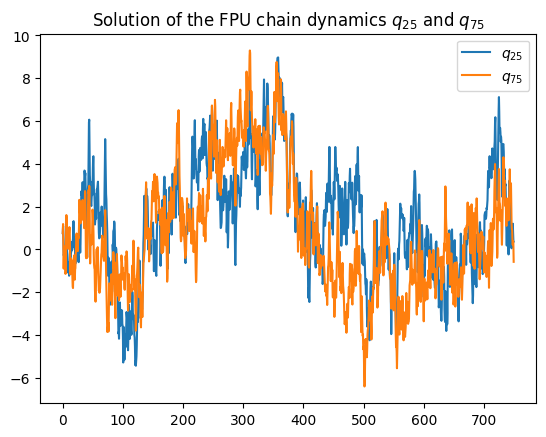

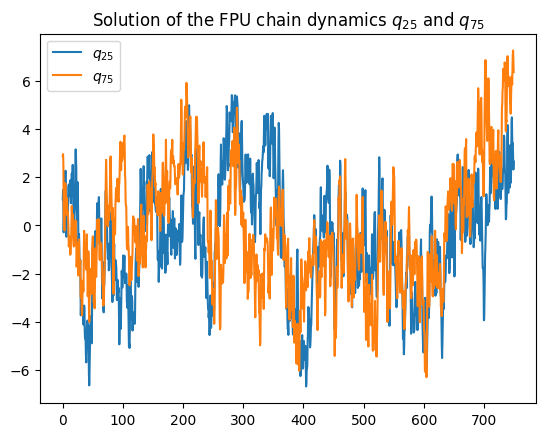

In [10]:
for i, local_q25_store, local_q75_store in results:
        q25_store[:, i*minibatch:(i+1)*minibatch] = local_q25_store
        q75_store[:, i*minibatch:(i+1)*minibatch] = local_q75_store

Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


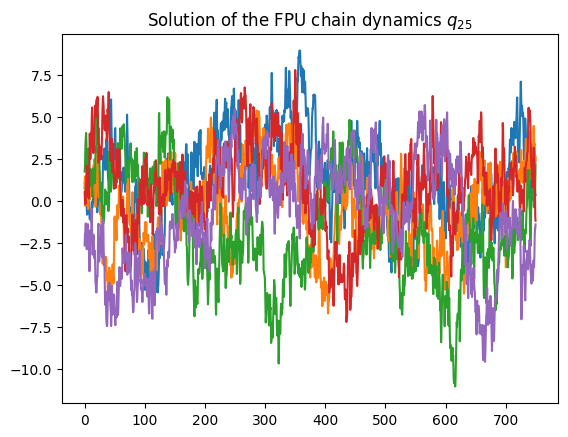

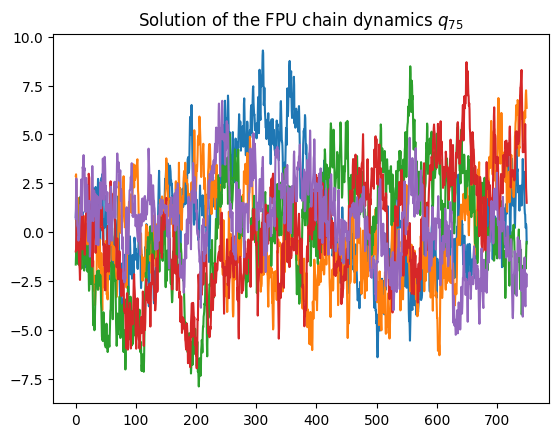

In [11]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [12]:
seed = 6666
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [13]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [14]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


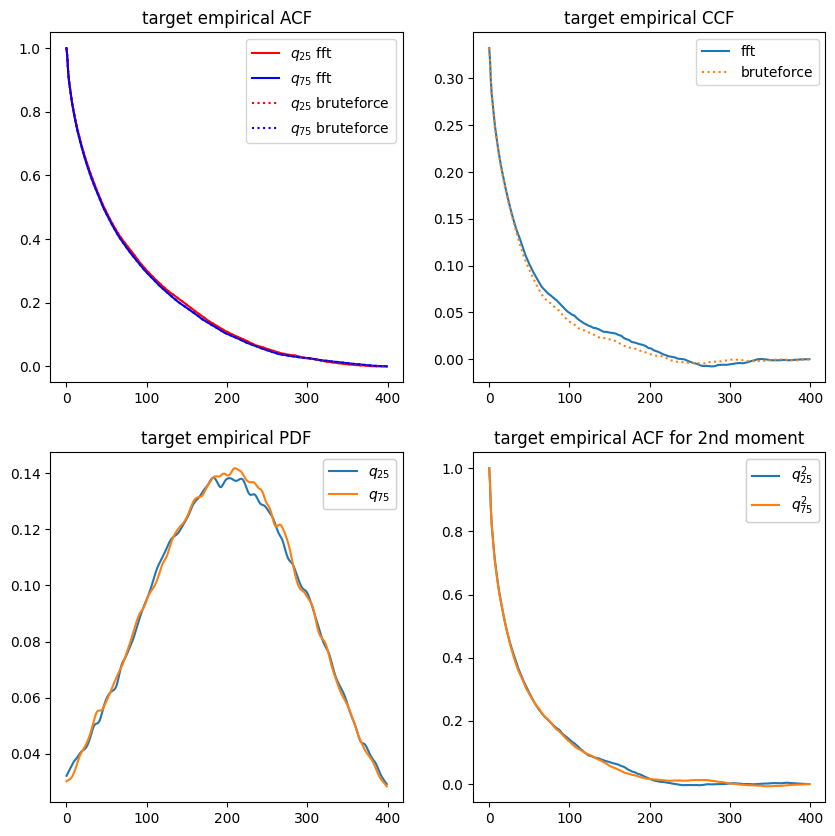

In [15]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

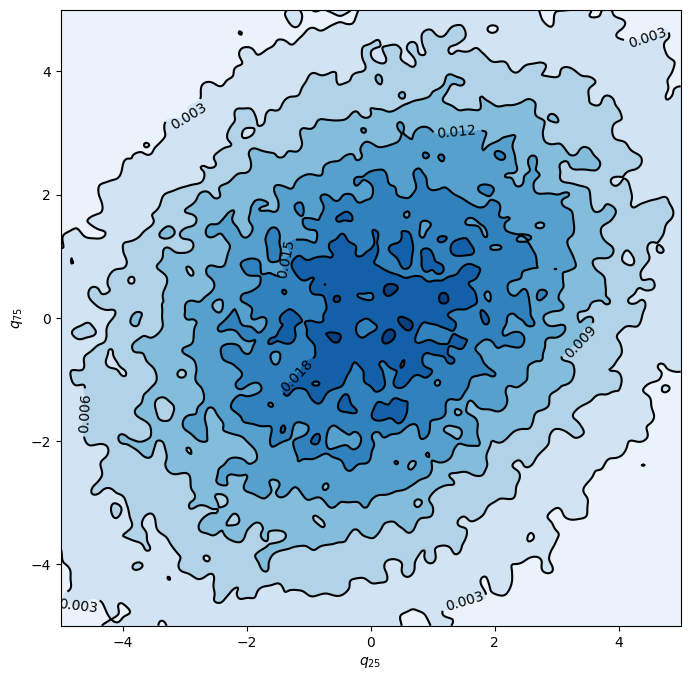

In [ ]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

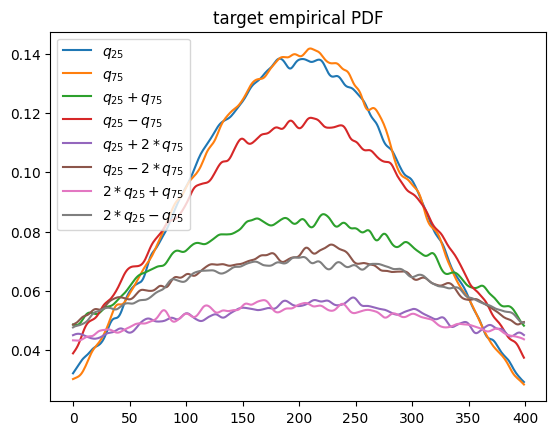

In [17]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [18]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [19]:
model_type = 1

In [20]:
### Defining SINN model
net = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.7054, 0.6840, acf: 0.07369, ccf: 0.00585, pdf: 0.28784, pdf2: 0.28648, acf2: 0.03008
[50]-th step loss: 0.0560, 0.0570, acf: 0.01137, ccf: 0.03032, pdf: 0.00920, pdf2: 0.00539, acf2: 0.00068
[100]-th step loss: 0.0625, 0.0623, acf: 0.04081, ccf: 0.00543, pdf: 0.00775, pdf2: 0.00133, acf2: 0.00696
[150]-th step loss: 0.0531, 0.0505, acf: 0.02493, ccf: 0.01210, pdf: 0.00700, pdf2: 0.00187, acf2: 0.00462
[200]-th step loss: 0.0297, 0.0278, acf: 0.00934, ccf: 0.00906, pdf: 0.00595, pdf2: 0.00164, acf2: 0.00185
[250]-th step loss: 0.0314, 0.0307, acf: 0.00566, ccf: 0.01752, pdf: 0.00248, pdf2: 0.00153, acf2: 0.00349
[300]-th step loss: 0.0216, 0.0216, acf: 0.00306, ccf: 0.01572, pdf: 0.00038, pdf2: 0.00094, acf2: 0.00152
[350]-th step loss: 0.0202, 0.0201, acf: 0.00313, ccf: 0.01485, pdf: 0.00032, pdf2: 0.00052, acf2: 0.00126
[400]-th step loss: 0.0156, 0.0141, acf: 0.00153, ccf: 0.00793, pdf: 0.00220, pdf2: 0.00098, acf2: 0.00151
[450]-th step loss: 0.0120, 0.0078, acf:

In [21]:
net.arch.input_size

2

In [22]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$L_2$ Loss',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [23]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [24]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [25]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

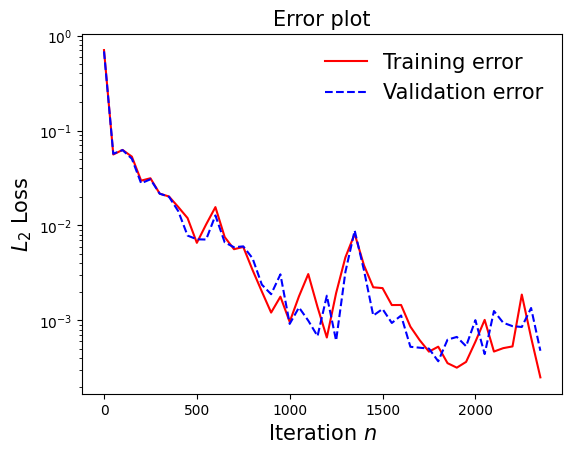

In [26]:
draw_loss(model)

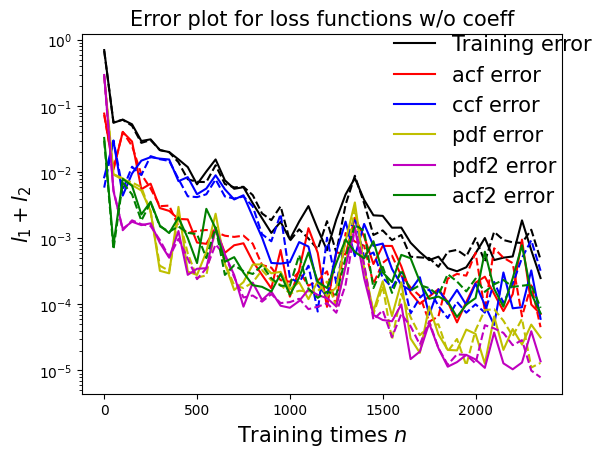

In [27]:
draw_errors(model)

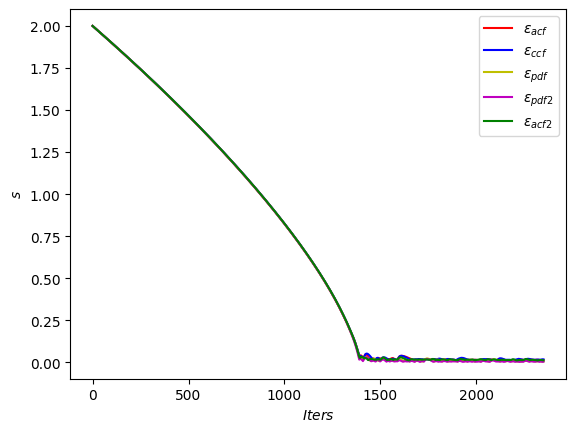

In [28]:
draw_adaptive_w(model)

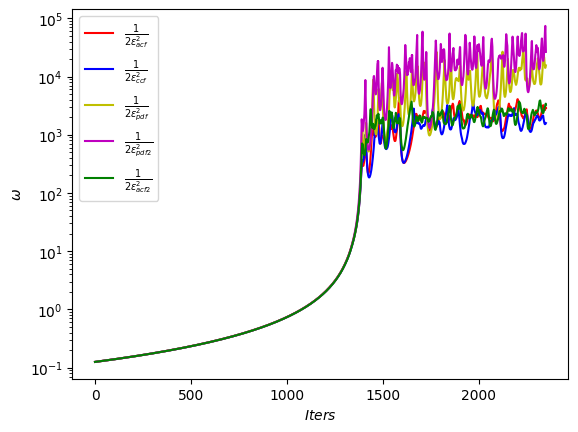

In [29]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [30]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [31]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [32]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [33]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [34]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [35]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [36]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

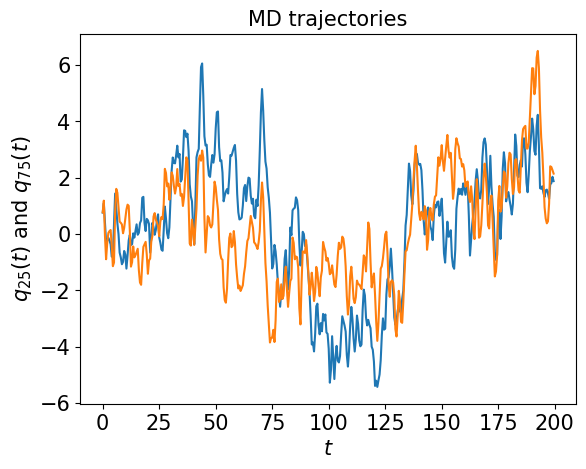

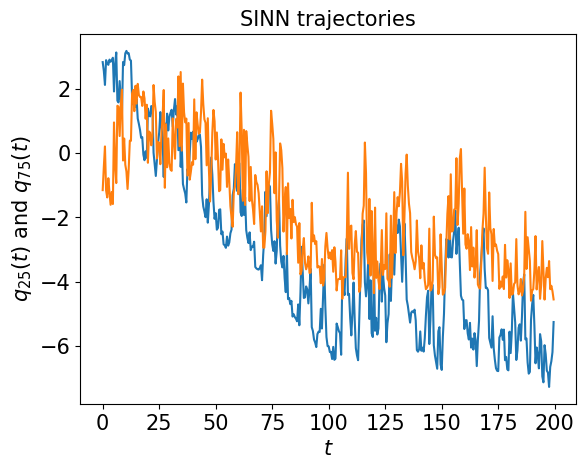

In [37]:
test1(model)

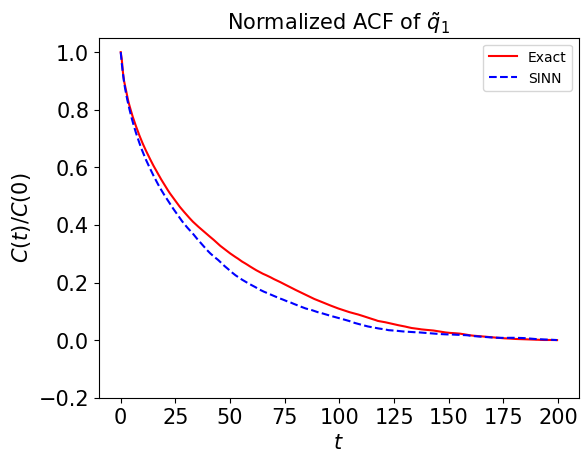

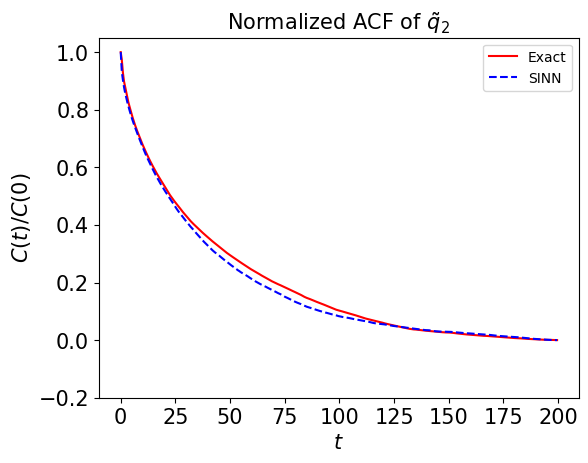

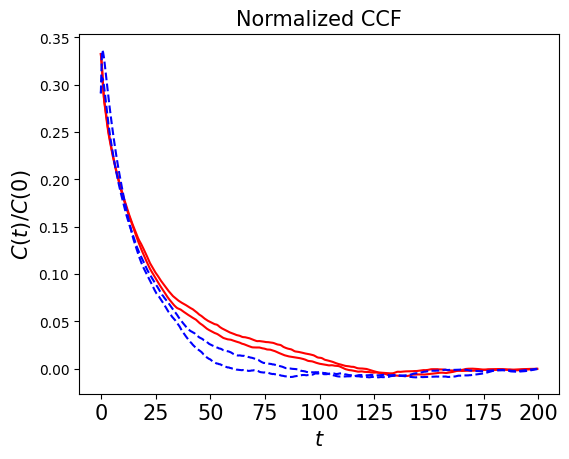

In [38]:
test2(model)

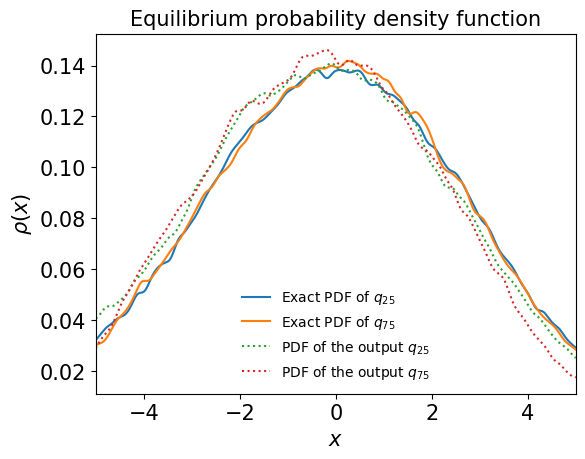

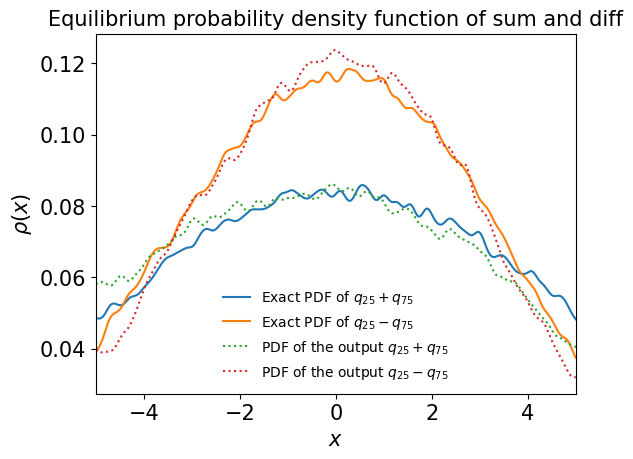

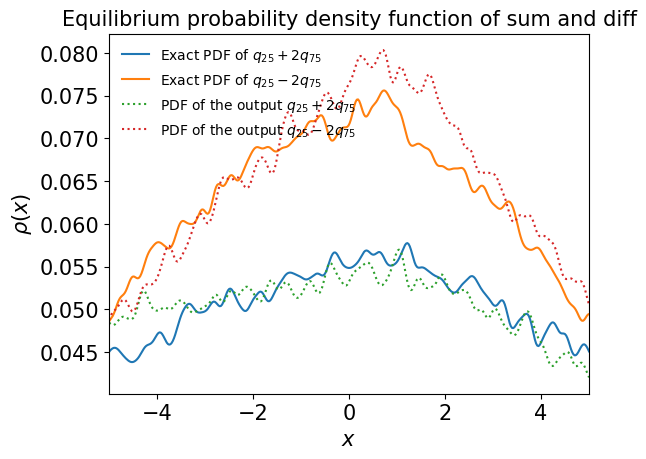

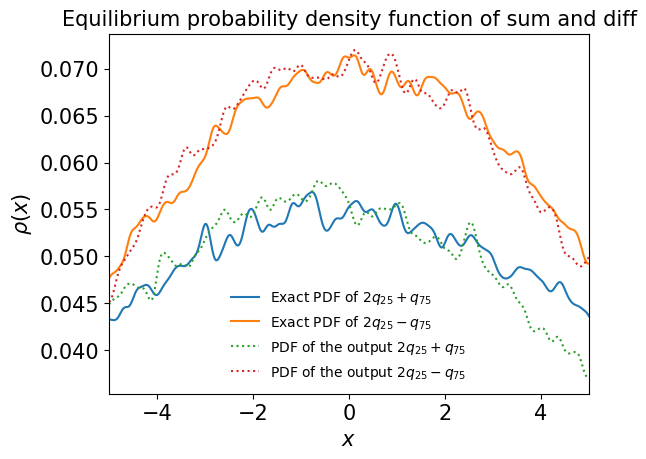

In [39]:
test3(model)

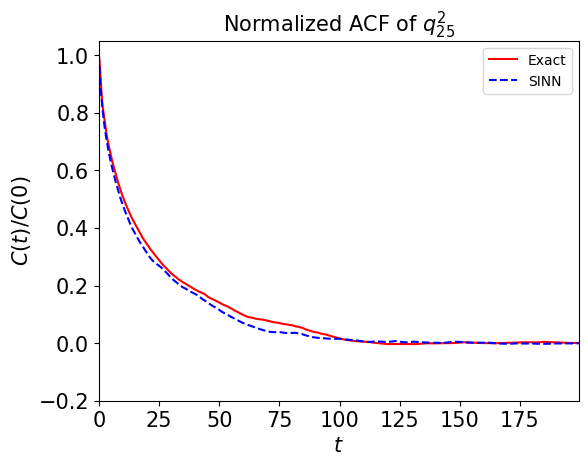

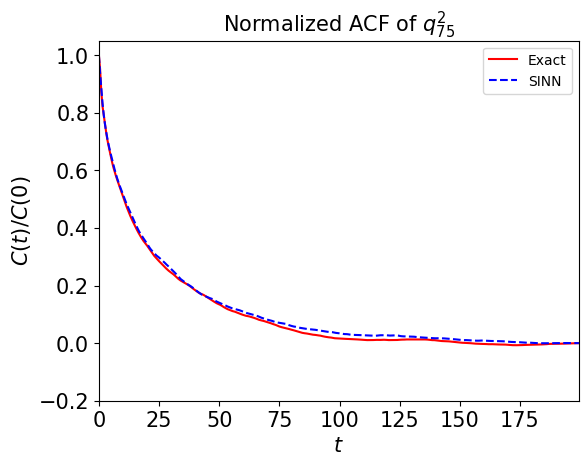

In [40]:
test4(model)

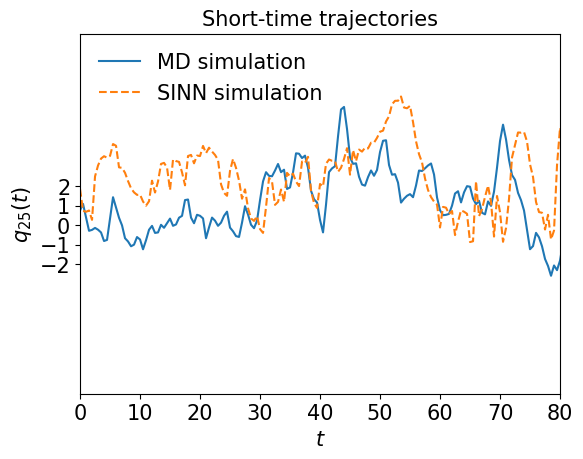

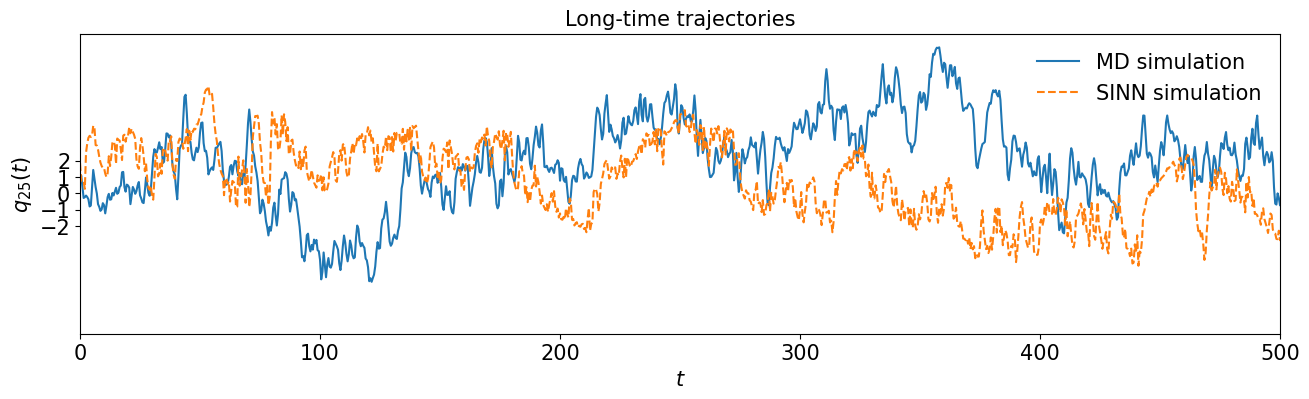

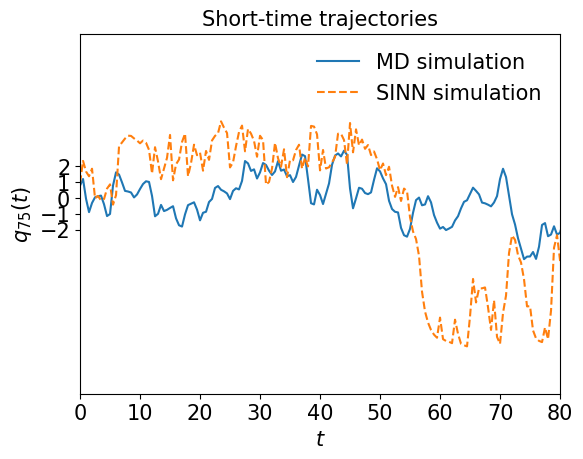

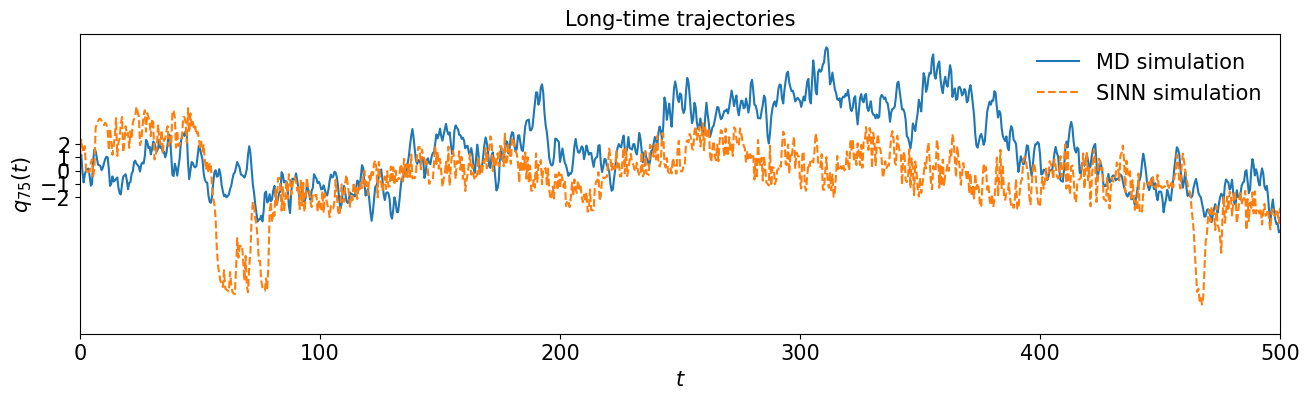

In [41]:
test5(model)

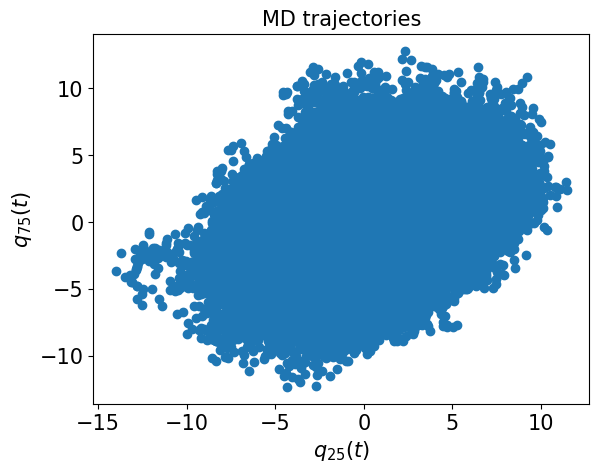

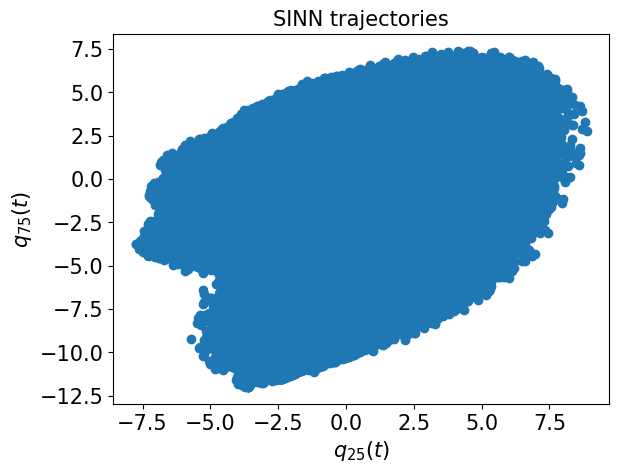

In [42]:
test6(model)

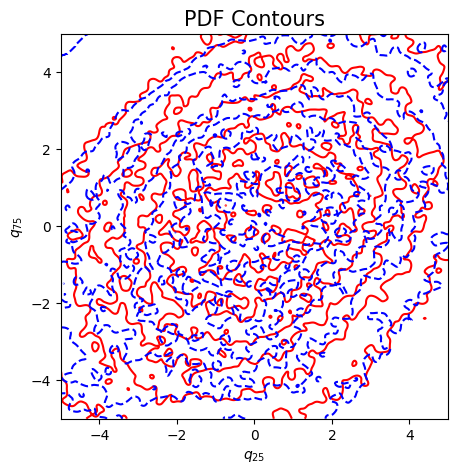

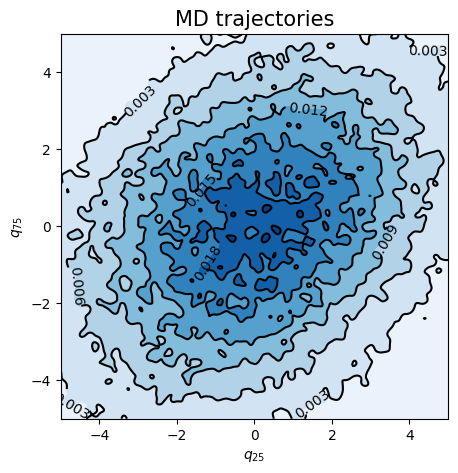

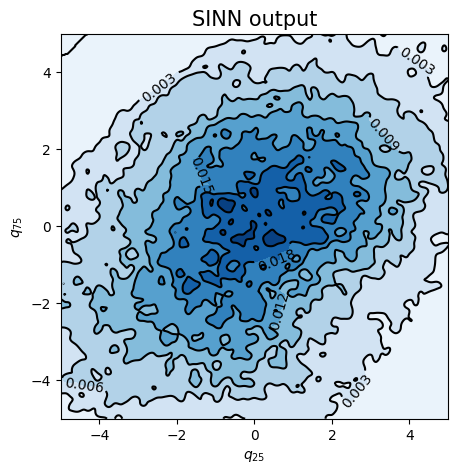

In [43]:
test7(model)

In [44]:
### Defining SINN model
net1 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.6969, 0.6641, acf: 0.07347, ccf: 0.00384, pdf: 0.28378, pdf2: 0.27307, acf2: 0.02997
[50]-th step loss: 0.0192, 0.0170, acf: 0.00601, ccf: 0.00570, pdf: 0.00289, pdf2: 0.00113, acf2: 0.00124
[100]-th step loss: 0.0121, 0.0108, acf: 0.00076, ccf: 0.00257, pdf: 0.00181, pdf2: 0.00143, acf2: 0.00420
[150]-th step loss: 0.0108, 0.0107, acf: 0.00209, ccf: 0.00086, pdf: 0.00245, pdf2: 0.00164, acf2: 0.00369
[200]-th step loss: 0.0093, 0.0080, acf: 0.00275, ccf: 0.00012, pdf: 0.00286, pdf2: 0.00149, acf2: 0.00081
[250]-th step loss: 0.0084, 0.0075, acf: 0.00165, ccf: 0.00027, pdf: 0.00269, pdf2: 0.00150, acf2: 0.00137
[300]-th step loss: 0.0043, 0.0052, acf: 0.00040, ccf: 0.00044, pdf: 0.00173, pdf2: 0.00157, acf2: 0.00112
[350]-th step loss: 0.0048, 0.0047, acf: 0.00094, ccf: 0.00040, pdf: 0.00156, pdf2: 0.00140, acf2: 0.00043
[400]-th step loss: 0.0042, 0.0043, acf: 0.00094, ccf: 0.00019, pdf: 0.00160, pdf2: 0.00111, acf2: 0.00048
[450]-th step loss: 0.0029, 0.0022, acf:

In [45]:
### Defining SINN model
net2 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.7034, 0.6818, acf: 0.07291, ccf: 0.00399, pdf: 0.28810, pdf2: 0.28699, acf2: 0.02979
[50]-th step loss: 0.0215, 0.0235, acf: 0.00166, ccf: 0.01344, pdf: 0.00488, pdf2: 0.00211, acf2: 0.00142
[100]-th step loss: 0.0535, 0.0516, acf: 0.00936, ccf: 0.01981, pdf: 0.01236, pdf2: 0.00854, acf2: 0.00157
[150]-th step loss: 0.0629, 0.0586, acf: 0.02272, ccf: 0.01126, pdf: 0.00958, pdf2: 0.00891, acf2: 0.00608
[200]-th step loss: 0.0266, 0.0256, acf: 0.00860, ccf: 0.00616, pdf: 0.00702, pdf2: 0.00321, acf2: 0.00057
[250]-th step loss: 0.0148, 0.0138, acf: 0.00223, ccf: 0.00171, pdf: 0.00544, pdf2: 0.00229, acf2: 0.00214
[300]-th step loss: 0.0139, 0.0137, acf: 0.00419, ccf: 0.00110, pdf: 0.00527, pdf2: 0.00194, acf2: 0.00116
[350]-th step loss: 0.0115, 0.0121, acf: 0.00225, ccf: 0.00075, pdf: 0.00538, pdf2: 0.00200, acf2: 0.00172
[400]-th step loss: 0.0108, 0.0109, acf: 0.00153, ccf: 0.00046, pdf: 0.00495, pdf2: 0.00213, acf2: 0.00186
[450]-th step loss: 0.0113, 0.0136, acf:

In [46]:
### Defining SINN model
net3 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.6963, 0.6643, acf: 0.07349, ccf: 0.00445, pdf: 0.28386, pdf2: 0.27235, acf2: 0.03014
[50]-th step loss: 0.0336, 0.0308, acf: 0.01907, ccf: 0.00210, pdf: 0.00489, pdf2: 0.00231, acf2: 0.00247
[100]-th step loss: 0.1132, 0.0853, acf: 0.04644, ccf: 0.01774, pdf: 0.01191, pdf2: 0.00341, acf2: 0.00583
[150]-th step loss: 0.0775, 0.0681, acf: 0.02747, ccf: 0.01454, pdf: 0.00771, pdf2: 0.00337, acf2: 0.01505
[200]-th step loss: 0.0381, 0.0368, acf: 0.00552, ccf: 0.02319, pdf: 0.00264, pdf2: 0.00283, acf2: 0.00261
[250]-th step loss: 0.0300, 0.0285, acf: 0.00335, ccf: 0.01782, pdf: 0.00310, pdf2: 0.00231, acf2: 0.00188
[300]-th step loss: 0.0265, 0.0250, acf: 0.00452, ccf: 0.01482, pdf: 0.00245, pdf2: 0.00226, acf2: 0.00098
[350]-th step loss: 0.0262, 0.0240, acf: 0.00351, ccf: 0.01498, pdf: 0.00246, pdf2: 0.00211, acf2: 0.00090
[400]-th step loss: 0.0223, 0.0246, acf: 0.00402, ccf: 0.01452, pdf: 0.00244, pdf2: 0.00194, acf2: 0.00172
[450]-th step loss: 0.0218, 0.0230, acf:

In [ ]:
### Defining SINN model
net4 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.7197, 0.7002, acf: 0.07424, ccf: 0.01466, pdf: 0.28927, pdf2: 0.29135, acf2: 0.03068
[50]-th step loss: 0.0309, 0.0409, acf: 0.00883, ccf: 0.01695, pdf: 0.00935, pdf2: 0.00316, acf2: 0.00261
[100]-th step loss: 0.0132, 0.0118, acf: 0.00451, ccf: 0.00049, pdf: 0.00377, pdf2: 0.00124, acf2: 0.00175
[150]-th step loss: 0.0347, 0.0315, acf: 0.01029, ccf: 0.01383, pdf: 0.00300, pdf2: 0.00260, acf2: 0.00182
[200]-th step loss: 0.0271, 0.0284, acf: 0.01639, ccf: 0.00453, pdf: 0.00413, pdf2: 0.00182, acf2: 0.00156
[250]-th step loss: 0.0107, 0.0130, acf: 0.00173, ccf: 0.00275, pdf: 0.00393, pdf2: 0.00205, acf2: 0.00249
[300]-th step loss: 0.0090, 0.0077, acf: 0.00113, ccf: 0.00091, pdf: 0.00312, pdf2: 0.00195, acf2: 0.00059
[350]-th step loss: 0.0089, 0.0080, acf: 0.00092, ccf: 0.00068, pdf: 0.00277, pdf2: 0.00181, acf2: 0.00179
[400]-th step loss: 0.0058, 0.0054, acf: 0.00065, ccf: 0.00033, pdf: 0.00203, pdf2: 0.00170, acf2: 0.00070
[450]-th step loss: 0.0146, 0.0142, acf:

In [ ]:
### Defining SINN model
net5 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

In [ ]:
### Defining SINN model
net6 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

In [ ]:
### Defining SINN model
net7 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

In [ ]:
### Defining SINN model
net8 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

In [ ]:
### Defining SINN model
net9 = SINN(2, 100, 3, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()